# Learning From the Pros: Extracting Professional Goalkeeper Technique from Broadcast Footage

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import math
import cv2
import gkpose as gk
import ast
import re
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from mplsoccer import VerticalPitch
from matplotlib.lines import Line2D
import statsmodels.api as sm

## Import and Prepare Data

In [2]:
#Import 3D pose keypoints
set_3d_df = pd.read_csv('data/pose_3d.csv', index_col=0)
set_3d_df = gk.getPhotoID(set_3d_df)

In [3]:
#Import 2D pose keypoints (given in image coordinates)
set_2d_df = pd.read_csv('data/pose_2d.csv', index_col=0)
set_2d_df = gk.getPhotoID(set_2d_df)

In [4]:
#Import StatsBomb 1v1 Data
converter = {
    'location':ast.literal_eval,
    'shot_end_location':ast.literal_eval,
    'shot_freeze_frame':ast.literal_eval
}
sb_df = pd.read_csv('data/1v1_events.csv', converters = converter, index_col=0)

In [5]:
#Inspect 3d pose dataset
set_3d_df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,file,photo_id
0,-0.187500,0.281250,-0.015079,-0.140625,0.140625,0.169988,-0.046875,-0.015625,-0.012308,0.046875,...,-0.21875,-0.011179,0.203125,-0.093750,0.066936,0.281250,0.000000,0.089892,382-2.png,382
1,0.171875,0.281250,0.033766,0.187500,0.140625,0.152587,0.031250,0.000000,-0.045793,-0.031250,...,-0.21875,0.033514,0.031250,-0.093750,0.138639,0.109375,-0.031250,0.116491,262-2.png,262
2,-0.093750,0.359375,0.016994,0.015625,0.234375,0.005835,-0.031250,0.015625,-0.043475,0.046875,...,-0.15625,-0.072264,0.234375,-0.046875,-0.004875,0.281250,0.062500,-0.011386,537-2.png,537
3,-0.156250,0.390625,-0.044468,-0.140625,0.171875,0.159150,-0.046875,0.000000,-0.028738,0.062500,...,-0.34375,-0.019926,0.234375,-0.234375,0.068202,0.359375,-0.140625,0.027107,476-2.png,476
4,-0.125000,0.406250,-0.001968,-0.125000,0.203125,0.166595,-0.062500,0.000000,-0.005656,0.078125,...,-0.28125,-0.014175,0.140625,-0.234375,0.037226,0.140625,-0.109375,0.019169,63.png,63


In [6]:
sb_df.head()

,under_pressure,shot_outcome_name,distance_to_goal,shot_angle,gk_name,gk_engage
0,1,Saved,13.453624,48.012788,Danijel Subašić,0.525588
1,0,Saved,14.866069,47.726311,David Ospina Ramírez,0.190261
2,0,Goal,13.892444,30.256437,Wojciech Szczęsny,0.580334
3,0,Goal,15.132746,7.594643,Wojciech Szczęsny,0.738818
4,0,Blocked,8.062258,60.255119,David Ospina Ramírez,0.447214


In [7]:
#Merge 3d and 2d pose data with 1v1 events data
set_3d_df = set_3d_df.merge(sb_df, left_on='photo_id', right_index=True, how='left')
set_2d_df = set_2d_df.merge(sb_df, left_on='photo_id', right_index=True, how='left')

In [8]:
#Store the 3d and 2d pose coordinates separately
sets_3d = set_3d_df.loc[:,'0':'47'].values
sets_2d = set_2d_df.loc[:,'0':'31'].values

## View-Invariance

In [9]:
#Get camera-view invariant dataset of 3d poses
cvi_arr = gk.cameraInvariantDataset(sets_3d)
sets_3d_cvi = gk.flipBehindPoses(cvi_arr)

In [10]:
#Create the view-invariant dataframe
set_3d_cvi_df = pd.DataFrame(sets_3d_cvi)
set_3d_cvi_df.columns = set_3d_cvi_df.columns.astype(str)
cols = ['file', 'photo_id', 'under_pressure',
       'shot_outcome_name', 'distance_to_goal',
       'shot_angle', 'gk_name', 'gk_engage']
set_3d_cvi_df[cols] = set_3d_df[cols]

In [11]:
#Create view-invariant array with GKEM included
keep_cols = np.array(list(range(48)) + ['gk_engage'])
sets_3d_cvi = set_3d_cvi_df.loc[:,keep_cols].values

In [12]:
set_3d_cvi_df.head()

,0,1,2,3,4,5,6,7,8,9,...,46,47,file,photo_id,under_pressure,shot_outcome_name,distance_to_goal,shot_angle,gk_name,gk_engage
0,-0.187270,0.281250,0.017709,-0.108971,0.140625,0.191825,-0.048300,-0.015625,-0.003981,0.047579,...,0.000000,0.039688,382-2.png,382,0,Saved,7.280110,74.054604,Jonas Lössl,0.566352
1,-0.084613,0.281250,-0.153368,-0.003635,0.140625,-0.241714,-0.055167,0.000000,0.005496,0.049572,...,-0.031250,-0.158665,262-2.png,262,1,Goal,11.180340,63.434949,Hugo Lloris,0.644981
2,-0.047243,0.359375,0.082741,0.014513,0.234375,-0.008219,-0.053391,0.015625,-0.004006,0.063689,...,0.062500,-0.222769,537-2.png,537,0,Goal,11.313709,45.000000,Mathew Ryan,1.000000
3,-0.157551,0.390625,0.039614,-0.042210,0.171875,0.208141,-0.054964,0.000000,-0.001450,0.065672,...,-0.140625,-0.156212,476-2.png,476,0,Saved,12.041595,4.763642,Tom Heaton,0.332182
4,-0.125000,0.406250,-0.001968,-0.125000,0.203125,0.166595,-0.062500,0.000000,-0.005656,0.078125,...,-0.109375,0.019169,63.png,63,0,Goal,8.485281,45.000000,Eiji Kawashima,0.687184


In [7]:
#Defines body pose skeleton for plots
mpii_edges = [[0, 1], [1, 2], [2, 6], [6, 3], [3, 4], [4, 5], 
              [10, 11], [11, 12], [12, 8], [8, 13], [13, 14], [14, 15], 
              [6, 8], [8, 9]]

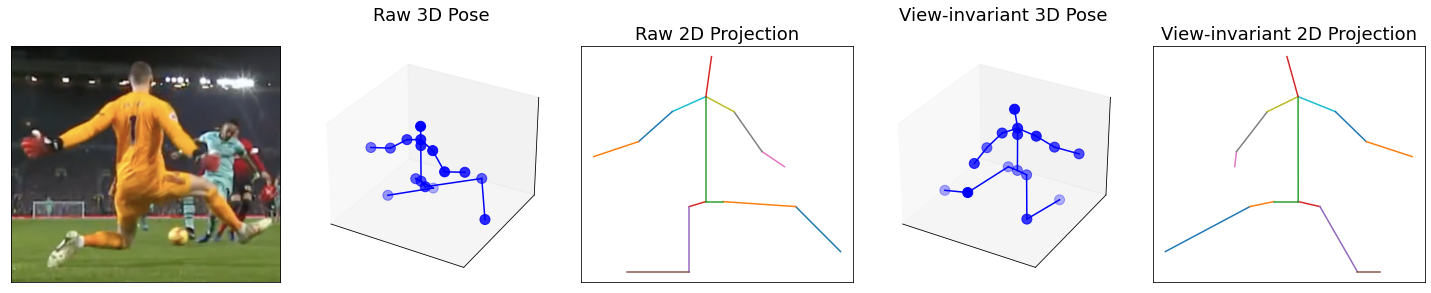

In [14]:
#Camera-view invariance example
pose_id = 319
photo_id = set_3d_df.loc[319,'file']
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(1, 5, 1)
path = 'images/1v1_images/'
ax.imshow(gk.importImage(path + photo_id))
ax.set_xticks([])
ax.set_yticks([])
ax = fig.add_subplot(1, 5, 2, projection='3d')
gk.plot3D(ax, gk.pose_to_matrix(sets_3d[pose_id]), mpii_edges)
ax.set_title('Raw 3D Pose', fontsize=18, pad=25)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax = fig.add_subplot(1, 5, 4, projection='3d')
gk.plot3D(ax, gk.pose_to_matrix(sets_3d_cvi[pose_id][:-1]), mpii_edges)
ax.set_title('View-invariant 3D Pose', fontsize=18, pad=25)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax = fig.add_subplot(1, 5, 3)
gk.plot2D(ax, gk.pose_to_matrix(sets_3d[pose_id]), mpii_edges)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Raw 2D Projection', fontsize=18)
ax = fig.add_subplot(1, 5, 5)
gk.plot2D(ax, gk.pose_to_matrix(sets_3d_cvi[pose_id][:-1]), mpii_edges)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('View-invariant 2D Projection', fontsize=18)
plt.tight_layout()
plt.show()

In [15]:
sets_3d_cvi_clean, set_3d_cvi_clean_df = gk.cleanPredictions(set_3d_cvi_df)

## Learning Save Technique - Unsupervised Learning

In [16]:
#Create 3D - 2D projection dataset
to_delete = np.array([ x-1 for x in range(0,49) if x%3==0][1:])
sets_2d_proj = np.delete(sets_3d_cvi_clean, to_delete, 1)

In [17]:
#Train K-Means 
kmeans = KMeans(n_clusters=4, random_state = 689).fit(sets_2d_proj)

In [18]:
#Get cluster membership label for each save - represents chosen save technique
kmeans_preds = kmeans.predict(sets_2d_proj)

In [19]:
np.unique(kmeans_preds, return_counts=True)[1]

array([106, 172, 109,  22])

In [20]:
#Clusters are named using domain knowledge
cluster_name = ['Aggressive Set', 'Passive Set', 'Spread', 'Smother']

In [21]:
#Get 2D TSNE representation of body pose (1244)
pose_tsne = TSNE(n_components=2, random_state=1445).fit_transform(sets_2d_proj)

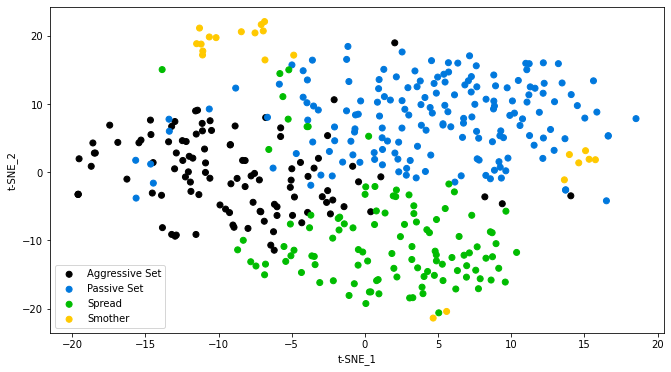

In [22]:
plt.figure(figsize=(11, 6))
for i in range(4):
    current_pose_type = pose_tsne[kmeans_preds == i]
    colors_kmeans = cm.nipy_spectral(kmeans_preds[kmeans_preds==i].astype(float) / 4)
    plt.scatter(current_pose_type[:,0], current_pose_type[:,1], 
                c=colors_kmeans, label=cluster_name[i])
plt.xlabel('t-SNE_1')
plt.ylabel('t-SNE_2')
plt.legend()
plt.show()

In [23]:
#Find saves that are closest to cluster centres
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, sets_2d_proj)

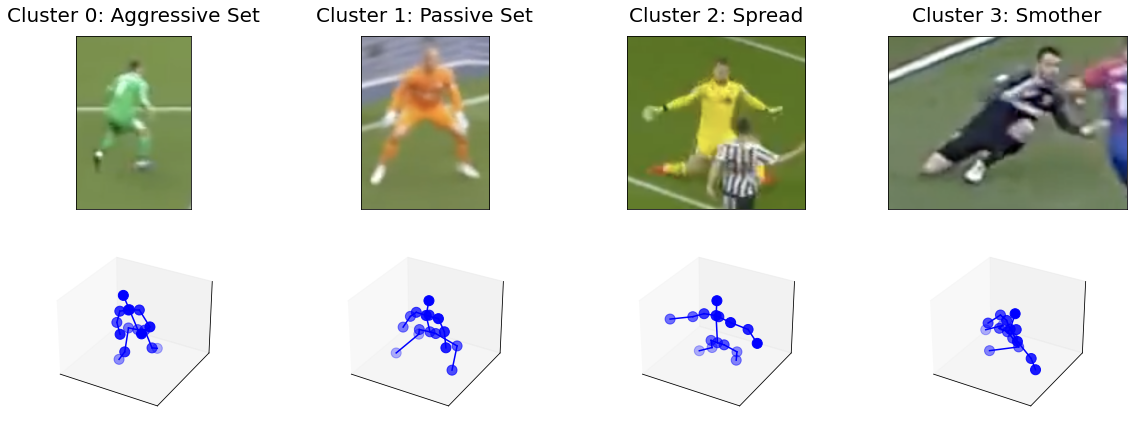

In [24]:
#Plot the most representative saves for each cluster
path = 'images/1v1_images/' #set 1v1 image path 
fig = plt.figure(figsize=(20,7))
for i in range(4):
    photo_id = gk.ImageID(set_3d_cvi_clean_df, closest[i])
    ax = fig.add_subplot(2, 4, i+1)
    ax.imshow(gk.importImage(path + photo_id))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Cluster ' + str(i) + ': ' + cluster_name[i], size=20, pad=15)

    ax = fig.add_subplot(2, 4, 5+i, projection='3d')
    gk.plot3D(ax, gk.pose_to_matrix(sets_3d_cvi_clean[closest[i]][:-1]), mpii_edges)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

## 1v1 Expected Saves Model

In [25]:
#Get data for xS model
df = set_3d_cvi_clean_df.loc[:,'file':]
df['cluster'] = kmeans_preds #Add save technique as feature

In [26]:
df.head(2)

,file,photo_id,under_pressure,shot_outcome_name,distance_to_goal,shot_angle,gk_name,gk_engage,cluster
0,382-2.png,382,0,Saved,7.280110,74.054604,Jonas Lössl,0.566352,1
1,537-2.png,537,0,Goal,11.313709,45.000000,Mathew Ryan,1.000000,1


In [27]:
#Get train/test split
np.random.seed(3615)
train_df, test_df = gk.getTrainTest(df, test_size=0.3)

[119  93 132  10 218 190  91 176   3 178 133 162  87  71 243 294  45  24
 294  26  90  19 120   4 246   8 173  62 285   5  49  35 299  22  74 297
 270 269   5 277  44 294 235 199 123 213  79 259  15 120 292  79 224  35
 231 233  89 277  65 186  76 139 130 210 205 113  97 102 156 145 145 134
  13 200 114 152  98 196 138 139 201 159  53 129  84 102 119  35  67 236
 184   0]


In [28]:
#Clean train/test sets
train_gk_name = train_df['gk_name']
train_photo_id = train_df['photo_id']
test_gk_name = test_df['gk_name']
test_photo_id = test_df['photo_id']

train_df.drop('photo_id', axis=1, inplace=True)
test_df.drop('photo_id', axis=1, inplace=True)
train_df.drop('gk_name', axis=1, inplace=True)
test_df.drop('gk_name', axis=1, inplace=True)

In [29]:
#Scale the numerical features by removing mean and scaling to unit variance
features_to_scale = ['shot_angle','distance_to_goal']
scaler = StandardScaler().fit(train_df[features_to_scale])
train_df[features_to_scale] = scaler.transform(train_df[features_to_scale])
test_df[features_to_scale] = scaler.transform(test_df[features_to_scale])

In [30]:
#Get training set X and y
y_train = train_df.pop('shot_outcome_name')
X_train = train_df.values
#Get test set X and y
y_test = test_df.pop('shot_outcome_name')
X_test = test_df.values
print("Training Set Size:", len(X_train))
print("Test Set Size:", len(X_test))

Training Set Size: 227
Test Set Size: 92


In [31]:
np.mean(y_train == 1)

0.47577092511013214

In [32]:
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':('linear', 'rbf'), 'C':[0.1, 1, 10, 100]}
svm = GridSearchCV(SVC(probability=True), param_grid=parameters, cv=5, scoring='accuracy').fit(X_train, y_train)
print("Best Parameter Set:", svm.best_params_)
print("Test Set Accuracy:", np.mean(svm.predict(X_test) == np.array(y_test))*100)

Best Parameter Set: {'C': 1, 'kernel': 'rbf'}
Test Set Accuracy: 68.47826086956522


In [33]:
#Calculate xS map when striker is not under pressure
xs_map = gk.getXSMap(train_df, svm, scaler, num_clusters=4, up=0)

done cluster 0
done cluster 1
done cluster 2
done cluster 3


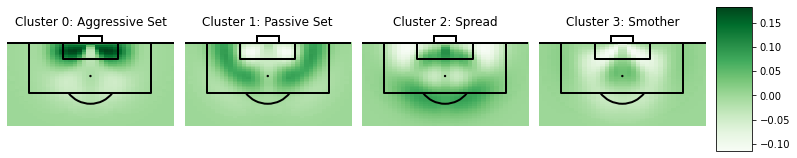

In [34]:
gk.plotXSMap(xs_map, num_clusters=4, cluster_names=cluster_name)

In [35]:
#Calculate xS map for when striker is under pressure
xs_map_up = gk.getXSMap(train_df, svm, scaler, num_clusters=4, up=1)

done cluster 0
done cluster 1
done cluster 2
done cluster 3


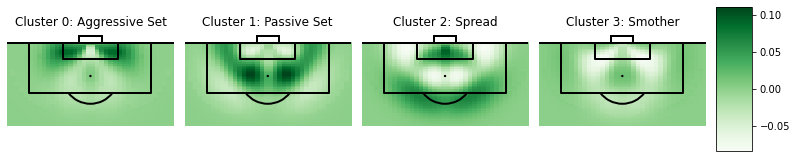

In [36]:
gk.plotXSMap(xs_map_up, num_clusters=4, cluster_names=cluster_name)

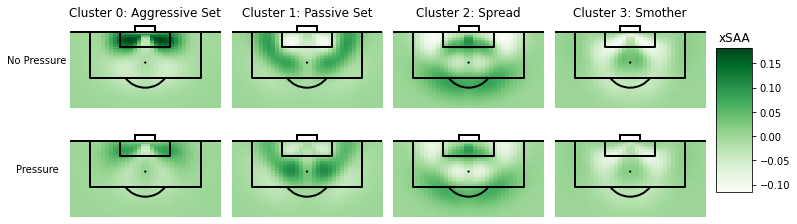

In [37]:
gk.plotDoubleXSMap(xs_map, xs_map_up, cluster_name)

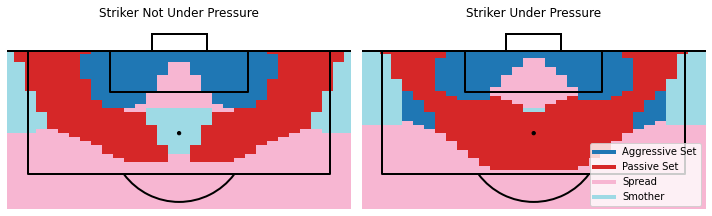

In [38]:
gk.plotBestTechniqueUp(xs_map, xs_map_up, cluster_name)

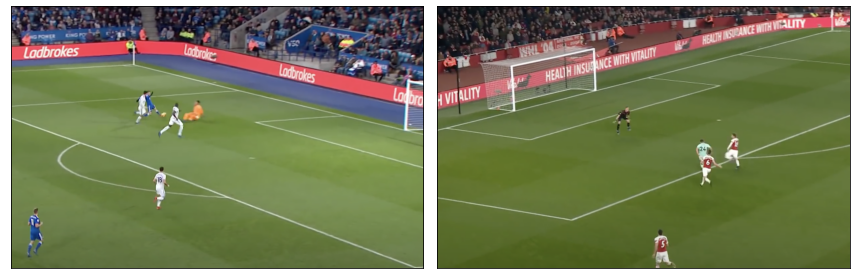

In [39]:
image = gk.importImage('images/example1.png')
image1 = gk.importImage('images/example2.png')
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].imshow(image)
ax[1].imshow(image1)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.tight_layout()
plt.show()

In [40]:
#Neil Etheridge
print("Actual: Smother", svm.predict_proba(np.array([0.69060136,1.5159017,0,0,0,0,1]).reshape(1,-1)))
print("Aggressive Set", svm.predict_proba(np.array([0.69060136,1.5159017,0,1,0,0,0]).reshape(1, -1)))
print("Passive Set", svm.predict_proba(np.array([0.69060136,1.5159017,0,0,1,0,0]).reshape(1, -1)))
print("Spread", svm.predict_proba(np.array([0.69060136,1.5159017,0,0,0,1,0]).reshape(1, -1)))

Actual: Smother [[0.52647476 0.47352524]]
Aggressive Set [[0.49192876 0.50807124]]
Passive Set [[0.41266331 0.58733669]]
Spread [[0.5 0.5]]


In [41]:
#Bernd Leno
print("Actual: Aggressive Set", svm.predict_proba(np.array([-0.15589943,1.8885945,0,1,0,0,0]).reshape(1, -1)))
print("Passive Set", svm.predict_proba(np.array([-0.15589943,1.8885945,0,0,1,0,0]).reshape(1, -1)))
print("Spread", svm.predict_proba(np.array([-0.15589943,1.8885945,0,0,0,1,0]).reshape(1, -1)))
print("Smother", svm.predict_proba(np.array([-0.15589943,1.8885945,0,0,0,0,1]).reshape(1, -1)))

Actual: Aggressive Set [[0.61326243 0.38673757]]
Passive Set [[0.53845087 0.46154913]]
Spread [[0.5210732 0.4789268]]
Smother [[0.60742645 0.39257355]]


## Pro Goalkeeper Scouting

In [42]:
#Reset the index of test set
test_df.reset_index(drop=True, inplace=True)

In [43]:
#Inspect test set
test_df.head()

,shot_angle,distance_to_goal,under_pressure,cluster_0,cluster_1,cluster_2,cluster_3
0,-1.953673,-1.260043,0,1,0,0,0
1,-0.140049,-1.505765,0,0,0,1,0
2,-0.646943,-1.635473,0,1,0,0,0
3,1.834208,0.543967,0,0,0,1,0
4,0.259869,-1.691865,0,0,0,0,1


In [44]:
#Derive the optimal save technique for each save
test_df['optimal_cluster'] = gk.getProsOptimalCluster(test_df, svm, num_clusters=4)
train_df['optimal_cluster'] = gk.getProsOptimalCluster(train_df, svm, num_clusters=4)

In [45]:
#The chosen technique for each save
test_df['chosen_cluster'] = np.argmax(test_df.filter(regex='cluster_').values, axis=1)
train_df['chosen_cluster'] = np.argmax(train_df.filter(regex='cluster_').values, axis=1)

In [46]:
#Rank Pro Goalkeepers by their % correct usage of save technique
test_df['gk_name'] = np.array(test_gk_name)
train_df['gk_name'] = np.array(train_gk_name)
gk_df = pd.concat([train_df[['gk_name','chosen_cluster','optimal_cluster']], test_df[['gk_name','chosen_cluster','optimal_cluster']]])
print("Percentage optimal:", np.mean(gk_df['chosen_cluster'] == gk_df['optimal_cluster']) * 100)
gk_df['correct_cluster'] = (gk_df['chosen_cluster'] == gk_df['optimal_cluster'])
gk_ranking = gk_df[['gk_name','correct_cluster']].groupby(['gk_name'], as_index=False).mean()
gk_ranking['shots_faced'] = np.array(gk_df.groupby(['gk_name'], as_index=False).count()['correct_cluster'])
gk_ranking.sort_values(by=['correct_cluster'], ascending=False, inplace=True)
gk_ranking.reset_index(drop=True, inplace=True)

Percentage optimal: 29.780564263322884


In [47]:
#Ranking of Pro Keepers with >= 15 1v1s faced
gk_ranking[gk_ranking['shots_faced'] >= 15].reset_index(drop=True)

,gk_name,correct_cluster,shots_faced
0,Neil Leonard Dula Etheridge,0.625000,16
1,Łukasz Fabiański,0.535714,28
2,Ben Foster,0.400000,20
3,Kasper Schmeichel,0.400000,20
4,David de Gea Quintana,0.277778,18
5,Hugo Lloris,0.200000,15
6,Sergio Rico González,0.150000,20
7,Jordan Pickford,0.111111,18


## Learning From The Pros

In [48]:
def getGKEM(amateur_1v1s):
    dist_to_goal = []
    striker_to_gk = []
    goal_angle = []
    for i in range(len(amateur_1v1s)):
        dist_to_goal.append(gk.distance_to_goal(amateur_1v1s['striker_x'][i], amateur_1v1s['striker_y'][i]))
        striker_to_gk.append(gk.distance_to_goal(amateur_1v1s['striker_x'][i], amateur_1v1s['striker_y'][i], amateur_1v1s['gk_x'][i], amateur_1v1s['gk_y'][i]))
        goal_angle.append(gk.goal_angle(amateur_1v1s['striker_x'][i], amateur_1v1s['striker_y'][i]))
    amateur_1v1s['gkem'] = np.array(striker_to_gk) / np.array(dist_to_goal)
    amateur_1v1s['distance_to_goal'] = dist_to_goal
    amateur_1v1s['goal_angle'] = goal_angle
    return amateur_1v1s

In [49]:
#Import and clean amateur 1v1s event data
amateur_1v1s = pd.read_csv('data/amateur_1v1.csv')
amateur_1v1s = amateur_1v1s[['X','Y','X2','Y2']]
amateur_1v1s.columns = ['striker_x','striker_y','gk_x','gk_y']
amateur_1v1s['striker_x'] = amateur_1v1s['striker_x'] * 120 / 100
amateur_1v1s['gk_x'] = amateur_1v1s['gk_x'] * 120 / 100
amateur_1v1s['striker_y'] = amateur_1v1s['striker_y'] * 80 / 100
amateur_1v1s['gk_y'] = amateur_1v1s['gk_y'] * 80 / 100
amateur_1v1s['under_pressure'] = 0
amateur_1v1s = getGKEM(amateur_1v1s)
amateur_1v1s.head()

,striker_x,striker_y,gk_x,gk_y,under_pressure,gkem,distance_to_goal,goal_angle
0,104.4,49.6,116.4,42.4,0,0.763997,18.317205,31.607502
1,106.8,51.2,116.4,43.2,0,0.721865,17.311268,40.314100
2,114.0,52.8,116.4,47.2,0,0.430986,14.136478,64.885165
3,106.8,45.6,114.0,41.6,0,0.574422,14.338759,22.988717
4,103.2,44.8,116.4,40.8,0,0.789408,17.472264,15.945396


In [50]:
#Import Amateur 3D poses
amateur_2d = pd.read_csv('data/amateur_2d_1v1s.csv', index_col=0)
amateur_3d = pd.read_csv('data/amateur_3d_1v1s.csv', index_col=0)
pose_3d = amateur_3d.values

In [51]:
#Get camera-view invariant dataset of 3d poses
pose_vi = gk.cameraInvariantDataset(pose_3d)
#Rotates the poses from images taken from behind by 180 degrees
pose_vi = gk.flipBehindPoses(pose_vi)

In [52]:
#Add GKEM to body pose matrix
add_gkem = pd.DataFrame(pose_vi)
add_gkem['gkem'] = amateur_1v1s['gkem']
pose_vi_gkem = add_gkem.values

In [53]:
#Create 3D - 2D projection dataset
to_delete = np.array([ x-1 for x in range(0,49) if x%3==0][1:])
pose_2d_proj = np.delete(pose_vi_gkem, to_delete, 1)

In [54]:
#Get technique from K-Means Model
amateur_technique_preds = kmeans.predict(pose_2d_proj)
amateur_1v1s['cluster'] = amateur_technique_preds

In [55]:
#Prepare model input
amateur_model_df = amateur_1v1s[['goal_angle','distance_to_goal','under_pressure','cluster']].copy()
amateur_model_df[['goal_angle','distance_to_goal']] = scaler.transform(amateur_model_df[['goal_angle','distance_to_goal']])
amateur_model_df = pd.get_dummies(amateur_model_df, columns=['cluster'])
amateur_model_df['cluster_3'] = 0
amateur_model_df.head()

,goal_angle,distance_to_goal,under_pressure,cluster_0,cluster_1,cluster_2,cluster_3
0,-0.398906,1.766568,0,0,1,0,0
1,0.029370,1.519387,0,0,1,0,0
2,1.238017,0.739271,0,0,0,1,0
3,-0.822862,0.788976,0,0,1,0,0
4,-1.169322,1.558948,0,0,1,0,0


In [56]:
#Convert model input to matrix
amateur_model_input = amateur_model_df.values

In [57]:
#Get xS from SVM Model
amateur_1v1s['xS'] = svm.predict_proba(amateur_model_input)[:,1]

In [58]:
amateur_1v1s['optimal_cluster'], amateur_1v1s['mean_xs'] = gk.getOptimalSaveTechnique(amateur_1v1s, amateur_model_df, svm, scaler)
amateur_1v1s['xSAA'] = amateur_1v1s['xS'] - amateur_1v1s['mean_xs']
print("% Correct Technique:", np.mean(amateur_1v1s['cluster'] == amateur_1v1s['optimal_cluster']))

% Correct Technique: 0.5555555555555556


In [59]:
amateur_1v1s.head(3)

,striker_x,striker_y,gk_x,gk_y,under_pressure,gkem,distance_to_goal,goal_angle,cluster,xS,optimal_cluster,mean_xs,xSAA
0,104.4,49.6,116.4,42.4,0,0.763997,18.317205,31.607502,1,0.453633,2,0.417078,0.036555
1,106.8,51.2,116.4,43.2,0,0.721865,17.311268,40.314100,1,0.548348,1,0.486871,0.061478
2,114.0,52.8,116.4,47.2,0,0.430986,14.136478,64.885165,2,0.537274,0,0.592451,-0.055178


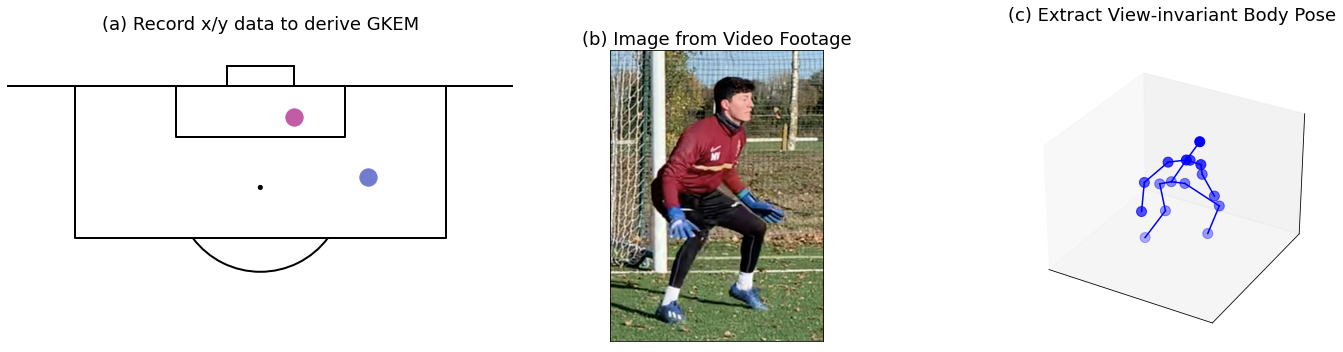

In [60]:
save_id = 7
ms = 300
path = 'images/amateur_1v1/'
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1, 3, 1)
pitch = VerticalPitch(half=True, goal_type='box', pad_bottom=-30, 
                      pad_left=-10, pad_right=-10, line_color='black')
pitch.draw(ax=ax)
pitch.scatter(amateur_1v1s.loc[save_id, 'striker_x'], amateur_1v1s.loc[save_id, 'striker_y'],
              c='#727cce', label='Striker', s=ms, ax=ax)
pitch.scatter(amateur_1v1s.loc[save_id, 'gk_x'], amateur_1v1s.loc[save_id, 'gk_y'],
              c='#c15ca5', label='Goalkeeper', s=ms, ax=ax)
ax.set_title('(a) Record x/y data to derive GKEM', fontsize=18, pad=23)
ax = fig.add_subplot(1, 3, 2)
ax.imshow(gk.importImage(path + str(save_id) + '.png'))
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('(b) Image from Video Footage', fontsize=18)
ax = fig.add_subplot(1, 3, 3, projection='3d')
gk.plot3D(ax, gk.pose_to_matrix(pose_3d[save_id]), mpii_edges)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_title('(c) Extract View-invariant Body Pose', fontsize=18, pad=30)
plt.tight_layout()
plt.show()

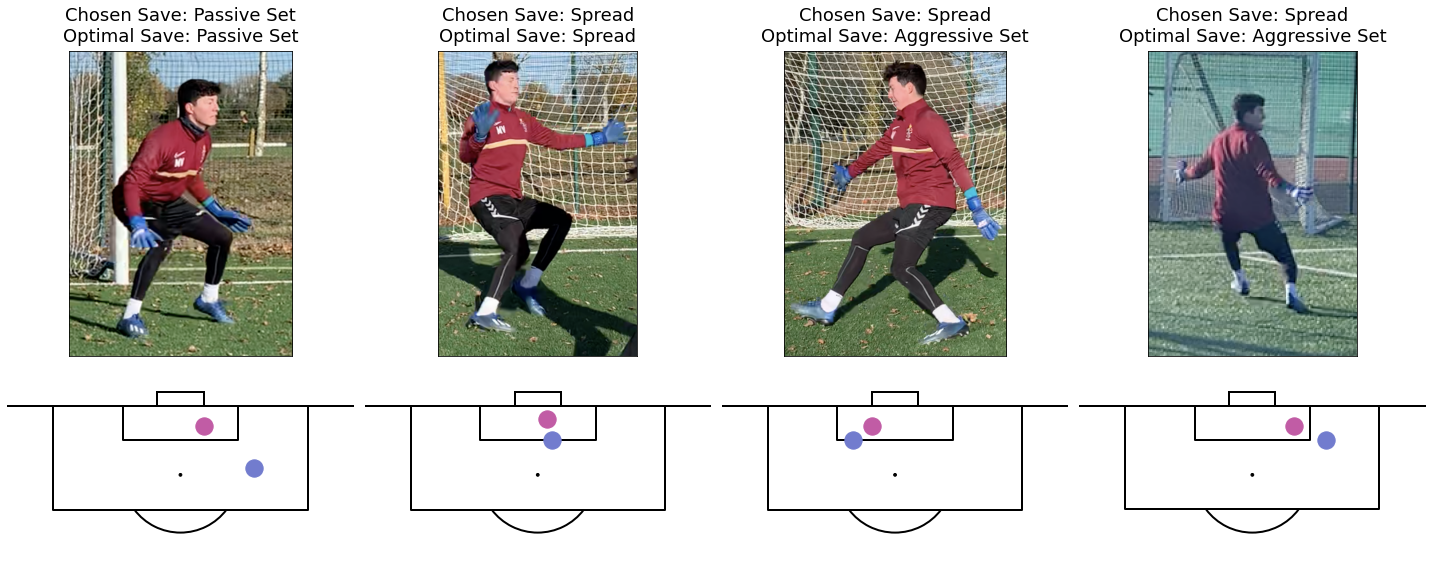

In [61]:
save_ids = [7,16,11,2]
saves_dict = {
    0: 'Aggressive Set',
    1: 'Passive Set',
    2: 'Spread',
    3: 'Smother'
}
fig = plt.figure(figsize=(20,9))
for i, save_id in enumerate(save_ids):
    #Images
    ax = fig.add_subplot(2, 4, i+1)
    ax.imshow(gk.importImage(path + str(save_id) + '.png'))
    ax.set_xticks([])
    ax.set_yticks([])
    chosen_save = saves_dict[amateur_1v1s.loc[save_id, 'cluster']]
    optimal_save = saves_dict[amateur_1v1s.loc[save_id, 'optimal_cluster']]
    ax.set_title('Chosen Save: ' + chosen_save + '\nOptimal Save: ' + optimal_save, 
                 fontsize=18, pad=10)
    #Pitches
    ax = fig.add_subplot(2, 4, i+5)
    pitch = VerticalPitch(half=True, goal_type='box', pad_bottom=-30, 
                          pad_left=-10, pad_right=-10, line_color='black')
    pitch.draw(ax=ax)
    pitch.scatter(amateur_1v1s.loc[save_id, 'striker_x'], amateur_1v1s.loc[save_id, 'striker_y'],
                  c='#727cce', label='Striker', s=ms, ax=ax)
    pitch.scatter(amateur_1v1s.loc[save_id, 'gk_x'], amateur_1v1s.loc[save_id, 'gk_y'],
                  c='#c15ca5', label='Goalkeeper', s=ms, ax=ax)
plt.tight_layout()
plt.show()

## Penalty Analysis

In [2]:
#3D pose data - 2019/20 and 2020/21
pose_3d_df = pd.read_csv('data/pen_pose_3d_19_20_20_21.csv', index_col=0)
pose_3d_2_df = pd.read_csv('data/pen_pose_3d_17_18_18_19.csv', index_col=0)
joined_pose_3d_df, pose_arr = gk.cleanPenDataFrames(pose_3d_df, pose_3d_2_df)

In [3]:
joined_pose_3d_df.head(3)

,pen_taker,outcome,goalkeepers,0,1,2,3,4,5,6,...,38,39,40,41,42,43,44,45,46,47
0,Bobby Reid,Goal,Artur Boruc,0.296875,0.312500,0.344790,0.078125,0.156250,0.217260,-0.015625,...,-0.081558,-0.296875,-0.093750,-0.181643,-0.234375,0.06250,-0.127242,-0.125000,0.375000,-0.030553
1,Eden Hazard,Goal,Karl Darlow,-0.171875,0.359375,0.165714,-0.156250,0.250000,0.315193,0.062500,...,0.029968,-0.171875,-0.234375,0.037787,0.203125,-0.03125,-0.065823,0.187500,0.234375,-0.155435
3,Joshua King,Goal,Jordan Pickford,-0.359375,0.406250,-0.032765,-0.156250,0.171875,0.101421,-0.078125,...,-0.129461,0.171875,-0.203125,-0.091516,0.203125,-0.03125,0.010528,0.234375,0.046875,-0.102935


In [4]:
#2D pose data
pose_2d_df = pd.read_csv('data/pen_pose_2d_19_20_20_21.csv', index_col=0)
pose_2d_2_df = pd.read_csv('data/pen_pose_2d_17_18_18_19.csv', index_col=0)
joined_pose_2d_df, pose_2d_arr = gk.cleanPenDataFrames(pose_2d_df, pose_2d_2_df)

In [5]:
#Percentage of pens that were saved in our dataset
np.mean(joined_pose_3d_df['outcome'] == 'Saved') * 100

16.260162601626014

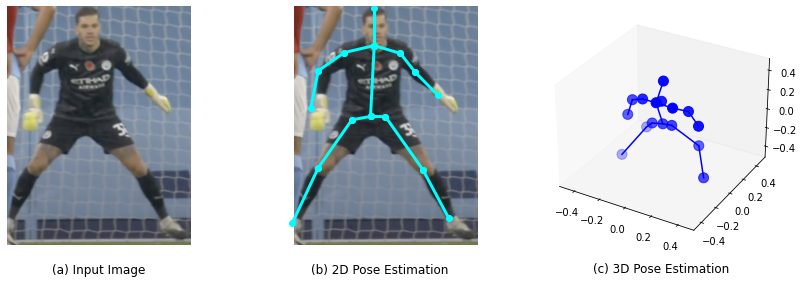

In [8]:
#Human Body Pose Estimation Example
#Show image, image with 2D pose overlay, and 3D pose estimate
photo_id = 315
array_id = gk.getArrayID(joined_pose_3d_df, photo_id)
image = gk.importImage('images/pen_images/combined_data/' + str(photo_id)+'.png')
pose_2d = gk.pose_to_matrix(pose_2d_arr[array_id])
points = gk.pose_to_matrix(pose_arr[array_id])

fig = plt.figure(figsize=(12, 4))
#fig.patch.set_visible(False)
ax = fig.add_subplot(1, 3, 1)
ax.imshow(image)
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
ax.set_title('(a) Input Image', y=-0.14)

ax = fig.add_subplot(1, 3, 2)
ax.imshow(image)
for e in range(len(mpii_edges)):
    ax.plot(pose_2d[mpii_edges[e]][:, 0], pose_2d[mpii_edges[e]][:, 1], c='cyan', lw=3, marker='o')
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
ax.set_title('(b) 2D Pose Estimation', y=-0.14)
    
ax = fig.add_subplot(1, 3, 3, projection='3d')
gk.plot3D(ax, points, mpii_edges)
ax.set_title('(c) 3D Pose Estimation', y=-0.15)
plt.tight_layout()
plt.show()

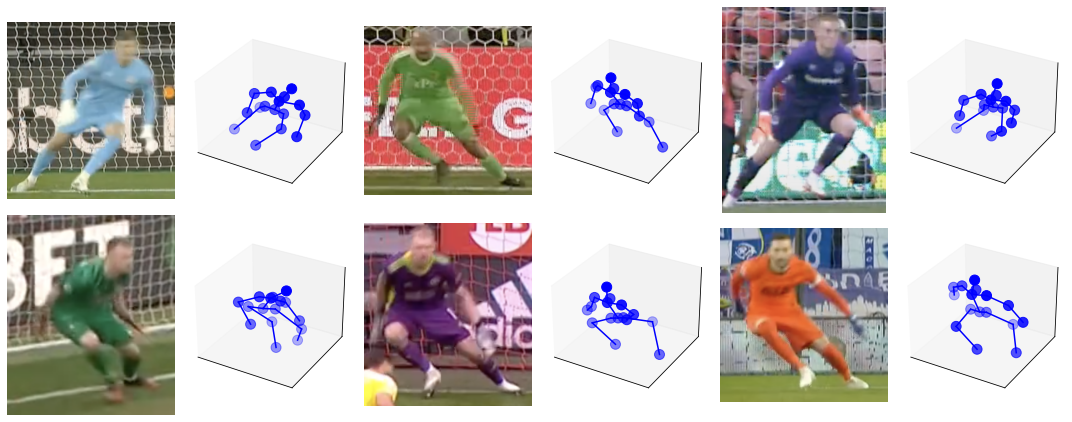

In [9]:
path = 'images/pen_images/combined_data/'
pic_ids = [388, 20, 3]
fig = plt.figure(figsize=(15, 6))

ax = fig.add_subplot(2, 6, 1)
ax.imshow(gk.importImage(path + str(pic_ids[0]) + '.png'))
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
ax = fig.add_subplot(2, 6, 2, projection='3d')
gk.plot3D(ax, gk.pose_to_matrix(pose_arr[gk.getArrayID(joined_pose_3d_df, pic_ids[0])]), mpii_edges)
ax.set_yticks([])
ax.set_xticks([])
ax.set_zticks([])

ax = fig.add_subplot(2, 6, 3)
ax.imshow(gk.importImage(path + str(pic_ids[1]) + '.png'))
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
ax = fig.add_subplot(2, 6, 4, projection='3d')
gk.plot3D(ax, gk.pose_to_matrix(pose_arr[gk.getArrayID(joined_pose_3d_df, pic_ids[1])]), mpii_edges)
ax.set_yticks([])
ax.set_xticks([])
ax.set_zticks([])

ax = fig.add_subplot(2, 6, 5)
ax.imshow(gk.importImage(path + str(pic_ids[2]) + '.png'))
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
ax = fig.add_subplot(2, 6, 6, projection='3d')
gk.plot3D(ax, gk.pose_to_matrix(pose_arr[gk.getArrayID(joined_pose_3d_df,pic_ids[2])]), mpii_edges)
ax.set_yticks([])
ax.set_xticks([])
ax.set_zticks([])

pic_ids = [243, 302, 377]

ax = fig.add_subplot(2, 6, 7)
ax.imshow(gk.importImage(path + str(pic_ids[0]) + '.png'))
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
ax = fig.add_subplot(2, 6, 8, projection='3d')
gk.plot3D(ax, gk.pose_to_matrix(pose_arr[gk.getArrayID(joined_pose_3d_df, pic_ids[0])]), mpii_edges)
ax.set_yticks([])
ax.set_xticks([])
ax.set_zticks([])

ax = fig.add_subplot(2, 6, 9)
ax.imshow(gk.importImage(path + str(pic_ids[1]) + '.png'))
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
ax = fig.add_subplot(2, 6, 10, projection='3d')
gk.plot3D(ax, gk.pose_to_matrix(pose_arr[gk.getArrayID(joined_pose_3d_df, pic_ids[1])]), mpii_edges)
ax.set_yticks([])
ax.set_xticks([])
ax.set_zticks([])

ax = fig.add_subplot(2, 6, 11)
ax.imshow(gk.importImage(path + str(pic_ids[2]) + '.png'))
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
ax = fig.add_subplot(2, 6, 12, projection='3d')
gk.plot3D(ax, gk.pose_to_matrix(pose_arr[gk.getArrayID(joined_pose_3d_df,pic_ids[2])]), mpii_edges)
ax.set_yticks([])
ax.set_xticks([])
ax.set_zticks([])

plt.tight_layout()
plt.show()

In [10]:
#Get camera-view invariant dataset of 3d poses
pen_pose_vi = gk.cameraInvariantDataset(pose_arr)
#Rotates the poses from images taken from behind by 180 degrees
pen_pose_vi = gk.flipBehindPoses(pen_pose_vi)

In [11]:
#Good Poses DataFrame
good_poses_3d_df = gk.cleanPenPredictions(joined_pose_3d_df)

In [12]:
good_poses_3d_df.head()

,pen_taker,outcome,goalkeepers,0,1,2,3,4,5,6,...,38,39,40,41,42,43,44,45,46,47
1,Eden Hazard,Goal,Karl Darlow,-0.171875,0.359375,0.165714,-0.156250,0.250000,0.315193,0.062500,...,0.029968,-0.171875,-0.234375,0.037787,0.203125,-0.031250,-0.065823,0.187500,0.234375,-0.155435
3,Joshua King,Goal,Jordan Pickford,-0.359375,0.406250,-0.032765,-0.156250,0.171875,0.101421,-0.078125,...,-0.129461,0.171875,-0.203125,-0.091516,0.203125,-0.031250,0.010528,0.234375,0.046875,-0.102935
4,Wayne Mark Rooney,Goal,Mathew Ryan,-0.171875,0.281250,-0.017270,-0.171875,0.062500,0.132535,-0.062500,...,-0.123473,0.078125,-0.062500,-0.169144,0.093750,0.062500,-0.114870,0.093750,0.187500,-0.189607
6,Glenn Murray,Saved,Kasper Schmeichel,-0.484375,0.343750,-0.040460,-0.296875,0.218750,0.226595,-0.109375,...,-0.030425,0.203125,-0.218750,-0.031844,0.265625,-0.046875,0.022101,0.125000,-0.062500,0.010645
13,Junior Stanislas,Goal,Wayne Hennessey,-0.343750,0.375000,-0.055004,-0.140625,0.218750,0.212009,-0.062500,...,-0.067645,0.203125,-0.234375,-0.074421,0.109375,-0.109375,0.054955,0.109375,-0.015625,0.026388


In [13]:
#Good Poses Matrix
good_poses_3d_arr = good_poses_3d_df.loc[:,'0':].values

In [14]:
#Convert all the good poses to the features space
poses_features = gk.PenFeatureSpace(good_poses_3d_arr)

In [15]:
kmeans_pens = KMeans(n_clusters=2, random_state = 13).fit(poses_features)

In [16]:
kmeans_pens_preds = kmeans_pens.predict(poses_features)

In [17]:
np.unique(kmeans_pens_preds, return_counts=True)[1]

array([ 86, 147])

In [18]:
print("Torso Angle, cluster 0", np.mean(poses_features[kmeans_pens_preds == 0][:,0]))
print("Body Angle, cluster 0", np.mean(poses_features[kmeans_pens_preds == 0][:,4]))

Torso Angle, cluster 0 36.49691170638337
Body Angle, cluster 0 27.50705103333253


In [19]:
print("Torso Angle, cluster 1", np.mean(poses_features[kmeans_pens_preds == 1][:,0]))
print("Body Angle, cluster 1", np.mean(poses_features[kmeans_pens_preds == 1][:,4]))

Torso Angle, cluster 1 10.798100113448712
Body Angle, cluster 1 16.379941711674892


In [20]:
pens_tsne = TSNE(n_components=2, random_state=29).fit_transform(poses_features)

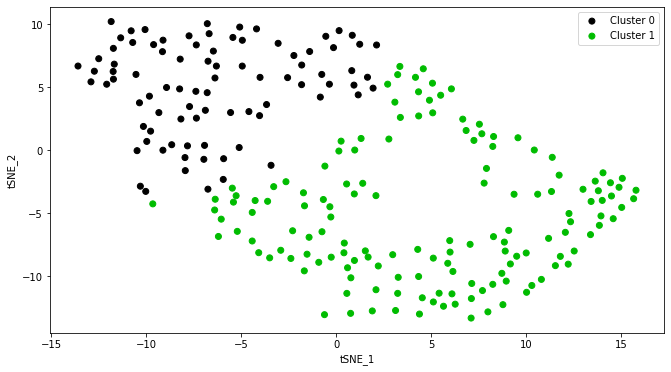

In [21]:
plt.figure(figsize=(11, 6))
for i in range(2):
    current_pose_type = pens_tsne[kmeans_pens_preds == i]
    colors_kmeans = cm.nipy_spectral(kmeans_pens_preds[kmeans_pens_preds==i].astype(float) / 2)
    plt.scatter(current_pose_type[:,0], current_pose_type[:,1], 
                c=colors_kmeans, label='Cluster ' + str(i))
plt.xlabel('tSNE_1')
plt.ylabel('tSNE_2')
plt.legend()
plt.show()

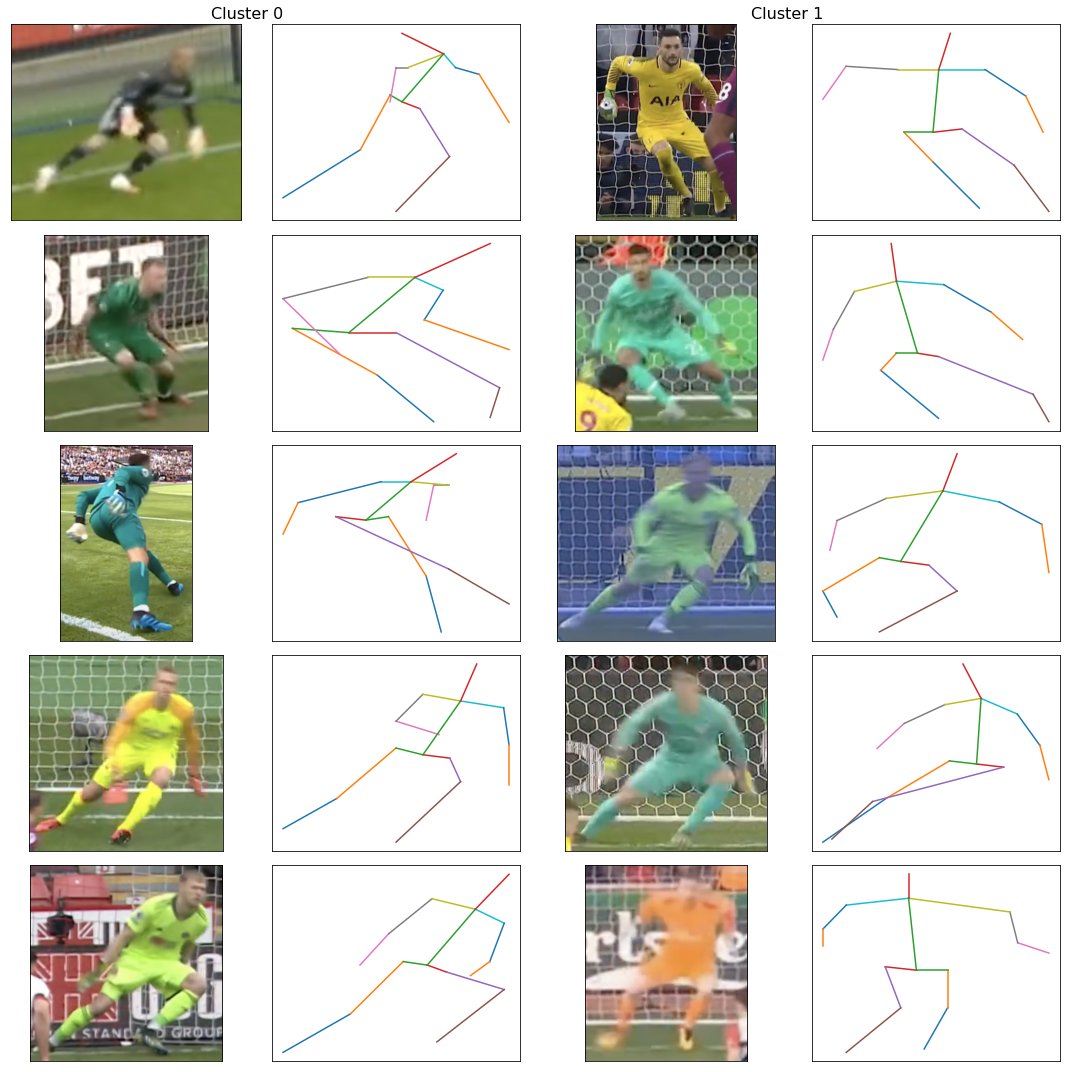

In [23]:
#GMM - 3D pose, 2D pose viz cluster examples
path = 'images/pen_images/combined_data/'
ax_array = [1, 5, 9, 13, 17]
fig = plt.figure(figsize=(15, 15))
for a in ax_array:
    arr_id = np.random.choice(np.where(kmeans_pens_preds == 0)[0])
    photo_id = gk.getImageID(good_poses_3d_df, arr_id)
    ax = fig.add_subplot(5, 4, a)
    ax.imshow(gk.importImage(path + str(photo_id) + '.png'))
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(5, 4, a+1)
    gk.plot2D(ax, gk.pose_to_matrix(good_poses_3d_arr[arr_id]), mpii_edges)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    if a == 1:
        ax.set_title('Cluster ' + str(0), position=(-0.1, 1), size=16)
        
    arr_id = np.random.choice(np.where(kmeans_pens_preds == 1)[0])
    photo_id = gk.getImageID(good_poses_3d_df, arr_id)
    ax = fig.add_subplot(5, 4, a+2)
    ax.imshow(gk.importImage(path + str(photo_id) + '.png'))
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(5, 4, a+3)
    gk.plot2D(ax, gk.pose_to_matrix(good_poses_3d_arr[arr_id]), mpii_edges)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    if a == 1:
        ax.set_title('Cluster ' + str(1), position=(-0.1, 1), size=16)
    
plt.tight_layout()
plt.show()

In [24]:
#Save % for cluster 0 saves
np.mean(good_poses_3d_df[kmeans_pens_preds == 0]['outcome'] == 'Saved')

0.18604651162790697

In [25]:
#Save % for cluster 1 saves
np.mean(good_poses_3d_df[kmeans_pens_preds == 1]['outcome'] == 'Saved')

0.14965986394557823

In [26]:
#Create dataframe of good poses features
good_poses_feat_df = pd.DataFrame({'outcome': good_poses_3d_df['outcome']})
good_poses_feat_df = pd.concat([good_poses_feat_df, pd.DataFrame(poses_features, index=good_poses_feat_df.index)], axis=1)
#Drops 8 observations where the strike was off target
good_poses_feat_df = good_poses_feat_df.loc[good_poses_feat_df['outcome']  != 'Off T',:]
good_poses_feat_df.columns = ['outcome','torso_angle','body_height','forward_step',
                              'hand_height','body_angle']

In [27]:
#Make target variable boolean - 1=Save, 0=Goal
good_poses_feat_df['outcome'] = np.array((good_poses_feat_df['outcome'] == 'Saved').astype(int))

In [28]:
continuous_var = ['torso_angle','body_height','forward_step','hand_height','body_angle']

In [29]:
#Train/Test Split (70/30)
split_index = good_poses_feat_df.index[int(len(good_poses_feat_df)*0.7)]
test_df = good_poses_feat_df.loc[split_index:, :].copy() 
train_df = good_poses_feat_df.loc[:split_index-1, :].copy() 

In [30]:
#Standardise continuous variables
scaler = StandardScaler()
scaler.fit(train_df[continuous_var])
train_df[continuous_var] = scaler.transform(train_df[continuous_var])
test_df[continuous_var] = scaler.transform(test_df[continuous_var])

In [31]:
#Add intercept term
train_df['coef'] = 1
test_df['coef'] = 1

In [32]:
train_df.head()

,outcome,torso_angle,body_height,forward_step,hand_height,body_angle,coef
1,0,-0.841042,0.704371,0.705889,-1.095364,0.033947,1
3,0,-0.303156,0.847432,-0.780754,0.363263,0.012007,1
4,0,-0.303156,-0.726240,-0.192359,-1.824677,-0.249652,1
6,1,-0.064290,0.847432,-1.102951,0.363263,0.777688,1
13,0,0.191781,0.561310,0.586017,0.800851,-0.288892,1


In [33]:
#Train logistic regression
log_reg = sm.Logit(train_df['outcome'], train_df[train_df.columns[1:]]).fit()

Optimization terminated successfully.
         Current function value: 0.476922
         Iterations 6


In [34]:
#Logistic regression summary
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                outcome   No. Observations:                  157
Model:                          Logit   Df Residuals:                      151
Method:                           MLE   Df Model:                            5
Date:                Sat, 15 Jan 2022   Pseudo R-squ.:                 0.02228
Time:                        11:10:48   Log-Likelihood:                -74.877
converged:                       True   LL-Null:                       -76.583
Covariance Type:            nonrobust   LLR p-value:                    0.6367
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
torso_angle      0.0447      0.263      0.170      0.865      -0.471       0.560
body_height     -0.1887      0.249     -0.759      0.448      -0.676       0.299
forward_step     0.0209      0.213      0.098      0.922      -0.396       0.438
hand_height      0.2170      0.229      0.946      0.344      -0.232       0.666
body_angle       0.2681      0.241      1.114      0.265      -0.203       0.740
coef            -1.4829      0.210     -7.073      0.000      -1.894      -1.072
================================================================================
"""

In [35]:
#Predictions
y_pred = log_reg.predict(test_df[test_df.columns[1:]])

In [36]:
#Prediction stats
print('Max xS:', np.max(y_pred))
print('Min xS:', np.min(y_pred))
print('Mean xS:', np.mean(y_pred))

Max xS: 0.32883922449476577
Min xS: 0.1051018893266706
Mean xS: 0.17710131737038703


In [37]:
y_pred[y_pred < 0.5] = 0

In [38]:
#Accuracy
np.mean(np.array(y_pred) == test_df['outcome'])

0.8823529411764706